In [44]:
import os
import sys
sys.path.insert(0, os.path.abspath('../src/'))
import units_ndarray as u
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc

In [45]:
#Some units and constants
eV = u.phval("eV")
au = u.phval("au")
Jy = u.phval("Jy")
kg = u.phval("kg")
Msun = u.phval("solarmass")
cm = u.phval("cm")
m = u.phval("m")
km = u.phval("km")
cm3 = u.phval("cm**3")
GeV = u.phval("GeV")
rho = 0.3*GeV/(cm**3)
s = u.phval("s")
MHz = u.phval("MHz")
pc = u.phval("pc")
kpc = 1000.*pc
Mpc = 1000.*kpc
K=u.phval("K")
yr=u.phval("yr")
W=u.phval("W")
mueV=1e-6*eV
deg=np.pi/180.
G=u.phval("G")
H=67.66*km/Mpc/s


In [46]:
def theta(l,b, oposite): #oposit=-1 means oposit direction
    galactic_center = np.array([1,0,0])
    source = np.array([np.cos(b)*np.cos(l), np.cos(b)*np.sin(l), np.sin(b)])
    return np.arccos(np.dot(galactic_center,oposite*source))

#old one, no big change
def flux(nu):
    S0=16.1e3*Jy          #value of the energy flux at the frequency nu0
    nu0=74.03*MHz         #nu0 frequency of the source  
    power = -0.58
    return S0*(nu/nu0)**power

#parametrization from ref [11]
def flux02(nu):
    a=4.695
    b=0.085
    c=-0.178
    return (10.**(a+b*np.log10(nu/MHz)+c*np.log10(nu/MHz)**2))*Jy

#some parameters for the calculation
l_S=76.189*deg  #Direction of the source
b_S=5.755*deg
th=theta(l_S,b_S,-1)/deg #angle between the direction oposite to the source and the GC in "deg"
print("Angle to GC: ", th)


sv = 120.*km/s    #DM dispersion velocity
tobs = yr/12.     #Obwervational time.

Angle to GC:  103.74001988874453


In [47]:
u.phval.use_units=True
def DpDnu(nu, tel): #eq 2.7, I guess this is the DpDnu measured by the telescope?
    if tel=="low":
        AcollEta = 419000.*m**2 * 0.8
    elif tel=="mid":
        AcollEta = 5659.*np.pi*((15.*m)**2)/4. # from the draft, but I don't understand!
    #print("DPDNU f2: ", (flux02(nu)).str("W/s"))
    #print("DPDNU f: ", (flux(nu)).str("W/s"))
    return flux02(nu)*AcollEta

def Tsky(nu):
    return 60.*K*(300.*MHz/nu)**2.55

def Tsys(nu, tel):
    if tel=="low":
        Trcvr = 20.*K
    elif tel=="mid":
        Trcvr = 40.*K
    return  Tsky(nu) + Trcvr

def DpminDnuTimesDnu(nu, time, tel):
    return 2.0*Tsys(nu, tel)*np.sqrt(nu*sv/time) #left hand side of eq.2.14 in the draft
    
#From here, right hand side of eq.2.14
    
def P1_over_g2(ma, Irho, time, tel):#right hand side of eq.2.14 without g^2
    #ma is the axion mass to be tesetd
    #Irho the integral along the line of rhoDM
    #time, the observational time
    #tel a string with the tlescope type "mid" or "low"
    nu=ma/(4*np.pi)
    return (1./16.)*Irho*DpDnu(nu, tel)

def P1(ma, ga, Irho, time, tel):#right hand side of eq.2.14 
    return ga**2*P1_over_g2(ma, Irho, time, tel)


#parameters for the NFW profile
RH=16.1*kpc     
rhoH = 1.4e7*Msun/(kpc)**3
print("Parameters for NFW profile: RH = " + RH.str("kpc") + " and  rhoH = " + rhoH.str("GeV/cm^3"))
#NFW profile with the parameters RH and rhoH.
def rho_NFW(r):
    return rhoH/((1.+r/RH)**2*r/RH)

#Distance to the galactic center in terms of the distance from the sun and the angle theta.
def r(d):
    Rs=8*kpc
    return d*np.sqrt((Rs/d-np.cos(th*deg))**2 + np.sin(th*deg)**2)#the same in the draft

def rho_NFW_Line(d):
    return rho_NFW(r(d))



Parameters for NFW profile: RH = 16.1 kpc and  rhoH = 0.5315123056327786 GeV/cm^3


In [51]:
def g_noise_one(ma, tel, time, Irho): #This is just g_{\gamma a a} the final result!
    return np.sqrt(DpminDnuTimesDnu(ma/(4.*np.pi), time, tel)/P1_over_g2(ma, Irho, time, tel))

#integral of rho
u.phval.use_units=False
integr=integrate.quad(rho_NFW_Line, 0.5*au, 300*kpc)[0]
u.phval.use_units=True

integral_rho = u.phval(integr, rho_NFW(kpc).units+kpc.units)#restore the units after the numerical calculation
print("Total DM Mass in a 1 square meter times 300kpc from the Sun: ",(integral_rho*m**2).str("kg"))

In [69]:
#benchmark numbers to test!
ma_low=1e-6*eV
ma_mid=1e-4*eV
nu_low=ma_low/(4*np.pi)
nu_mid=ma_mid/(4*np.pi)

print("Source")
print("Source Flux Low: ", flux02(nu_low).str(Jy))
print("Source Flux Mid: ", flux02(nu_mid).str(Jy))

print("\n Detection")
print("Tsky Low: ", Tsky(nu_low).str(K))
print("Tsky Mid: ", Tsky(nu_mid).str(K))
print("Tsys Low: ", Tsys(nu_low, "low").str(K))
print("Tsys Mid: ", Tsys(nu_mid, "mid").str(K))

print("\n Left Eq. Detection with 1yr")
time=yr
print("Minimum detectable power Low (Dp/Dnu Dnu): ", DpminDnuTimesDnu(nu_low, time, "low").str(W))
print("Minimum detectable power Mid (Dp/Dnu Dnu): ", DpminDnuTimesDnu(nu_mid, time, "mid").str(W))

print("\n Signal")
print("Dark matter at 8kpc: ",rho_NFW(8*kpc).str("GeV/cm^3"))
print("Total DM Mass in 1 m^2*300kpc from the Sun in the oposite direction of the source: ",(integral_rho*m**2).str("kg"))
print("Power of the signal for g_{\gamma a a}=1e-12 Low: ", P1(ma_low, 1e-11/GeV, integral_rho, time, "low").str(W))
print("Power of the signal for g_{\gamma a a}=1e-12 Mid: ", P1(ma_mid, 1e-11/GeV, integral_rho, time, "mid").str(W))

Source
Source Flux Low:  12592.461323186693 Jy
Source Flux Mid:  118.96644167551483 Jy

 Detection
Tsky Low:  609.015433013705 K
Tsky Mid:  0.004837581538256203 K
Tsys Low:  629.015433013705 K
Tsys Mid:  40.00483758153826 K

 Left Eq. Detection with 1yr
Minimum detectable power Low (Dp/Dnu Dnu):  6.801732125614743e-22 W
Minimum detectable power Mid (Dp/Dnu Dnu):  4.325842812070085e-22 W

 Signal
Dark matter at 8kpc:  0.4773829234955212 GeV/cm^3
Total DM Mass in 1 m^2*300kpc from the Sun in the oposite direction of the source:  0.28535541346082166 kg
Power of the signal for g_{\gamma a a}=1e-12 Low:  2.4981526045652788e-21 W
Power of the signal for g_{\gamma a a}=1e-12 Mid:  7.04110619238539e-23 W


In [49]:

u.phval.use_units=False
integr=integrate.quad(rho_NFW_Line, 0.5*au, 300*kpc)[0]
u.phval.use_units=True

integral_rho = u.phval(integr, rho_NFW(kpc).units+kpc.units)#restore the units after the numerical calculation
print("Total DM Mass in a 1 square meter times 300kpc from the Sun: ",(integral_rho*m**2).str("kg"))


Total DM Mass in a 1 square meter times 300kpc from the Sun:  0.28535541346082166 kg


Text(0.5, 0, '$m_a\\; ({\\rm eV})$')

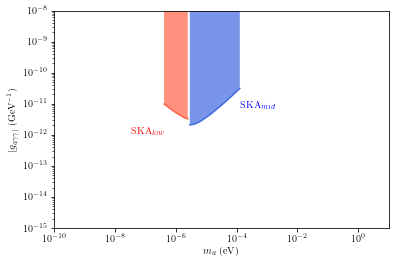

In [50]:
time=yr

fig, ax = plt.subplots(1)

#SKA low frequency range      *********************************************************************
numin_low=50*MHz
numax_low=300*MHz
tel="low"

#range of values of the axion mass in logscale for SKA_low 
x_low = np.logspace(np.log10(numin_low.values*4.*np.pi),np.log10(numax_low.values*4.*np.pi),200)*eV

#this computes the value fo g that equals signal and noise for every value of the frequency in the array x_low
y_low = g_noise_one(x_low,tel, time, integral_rho)
y_top = np.full(len(x_low), 1e-5)#top value, just to plot the region

c="tomato"
plt.plot(x_low/eV, y_low*GeV, color=c) #line
ax.fill_between(np.array(x_low/eV, dtype=float),np.array(y_low*GeV, dtype=float), y_top , facecolor=c, alpha=0.7)#region
ax.text(0.35e-7,1e-12, r"${\rm SKA}_{low}$", fontsize=10, color="red")#label


#SKA mid frequency range      *********************************************************************
#esentially the same as "low"
numin_mid=350*MHz
numax_mid=15.4*1e3*MHz
tel="mid"

x_mid = np.logspace(np.log10(numin_mid.values*4.*np.pi),np.log10(numax_mid.values*4.*np.pi),200)*eV
y_mid = g_noise_one(x_mid,tel, time, integral_rho)

c="royalblue"
plt.plot(x_mid/eV, y_mid*GeV, color=c)
ax.fill_between(np.array(x_mid/eV, dtype=float),np.array(y_mid*1e9, dtype=float), y_top , facecolor=c, alpha=0.7)

ax.text(1.3e-4,0.7e-11, r"${\rm SKA}_{mid}$", fontsize=10, color="blue")


#setting scales, labels ....
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-10, 10])
plt.ylim([1e-15,1e-8])

rc('text', usetex=True)
mpl.rcParams.update({'font.size': 11})
plt.ylabel(r"$|g_{a\gamma\gamma|}\; ({\rm GeV^{-1}})$")
plt.xlabel(r"$m_a\; ({\rm eV})$")
